In [2]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import copy
import requests

import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from lisc import Counts
from lisc.utils.db import SCDB
from lisc.utils.io import save_object
from lisc.plts.counts import plot_matrix
from wordcloud import WordCloud, get_single_color_func

from data.lisc_db.terms.terminology import stages, waves, eeg_features_2, additional_features

In [3]:
def run_and_save(counts, filename):
    counts.run_collection()
    main_dir = os.path.dirname(os.getcwd())
    db_dir = os.path.join(main_dir, 'data/', db.get_folder_path('counts'))
    save_object(counts, filename, directory=db_dir)

In [4]:
def load_counts(filename):
    main_dir = os.path.dirname(os.getcwd())
    data_rpath = db.get_file_path('counts', filename)
    data_abspath = os.path.join(main_dir, 'data/', data_rpath)
    return pd.read_pickle(data_abspath)

In [5]:
def pick_top(counts, top_n:int=None, percentile:float=None):
    counts = copy.deepcopy(counts)
    len_A = len(counts.terms['A'].terms)
    len_B = len(counts.terms['B'].terms)

    top = []
    if top_n:
        percentile = 0
    for i in range(len_A):
        for j in range(len_B):
            if counts.score[i][j] > counts.score.max() * percentile:
                top.append([counts.terms['A'].terms[i][0], counts.terms['B'].terms[j][0], counts.score[i][j]])

    top = sorted(top, key=lambda x: x[2], reverse=True)
    if top_n:
        top = top[:top_n]
    return top 

In [6]:
# initialize lisc SCDB (database) object.
db = SCDB('lisc_db')
db.gen_paths()

# **First, what are some memory concepts in "Working Memory" literature?**
We'll use concepts from the Cognitive Atlas - https://www.cognitiveatlas.org

In [7]:
url = "https://www.cognitiveatlas.org/concepts/categories/all"
page = requests.get(url)
data = page.text
soup = BeautifulSoup(data, 'html.parser')

# Let's cut down html into the categories of concepts
page_content = soup.find('div', id='pagecontent')
categories = page_content.find_all('h3')
categories = list(enumerate([category.get_text() for category in categories]))
categories

[(0, 'Classified under Action'),
 (1, 'Classified under Attention'),
 (2, 'Classified under Emotion'),
 (3, 'Classified under Executive/Cognitive Control'),
 (4, 'Classified under Language'),
 (5, 'Classified under Learning and Memory'),
 (6, 'Classified under Motivation'),
 (7, 'Classified under Perception'),
 (8, 'Classified under Reasoning and Decision Making'),
 (9, 'Classified under Social Function')]

In [8]:
# Select which category by index
category_idx = 5

# Obtain all the concept terms in the category you chose
category = soup.find(string=categories[category_idx][1]).parent
concepts = category.find_next_sibling('div').find_all('a')
concepts = [term.get_text() for term in concepts]

# Remove some words that aren't productive in "concepts".
remove = ['memory', 'skill', 'learning', 'knowledge']
concepts = [concept for concept in concepts if concept not in remove]

In [9]:
# Run co-occurances of "working memory" to the concepts
terms_a = ["working memory"]
terms_b = sorted(concepts) # alphabetical order

counts = Counts()
counts.add_terms(terms_a, dim='A')
counts.add_terms(terms_b, dim='B')

In [10]:
# Save the Counts data
run_and_save(counts, 'wm-memlrn.p')

In [10]:
# Load the counts data and compute its scores
pickle1 = load_counts('wm-memlrn.p')
pickle1.compute_score('normalize', dim='A')

# Prepare a wordcloud
                            
# LISC's wordcloud function won't suffice so we'll do it ourselves.
###################################################################

# Compile the words and frequencies into a dictionary to pass into the WordCloud object.
# Conveniently, our data is already 1D.
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
# Tweak the parameters to produce a beautiful wordcloud.
wc = WordCloud(width=2560, height=1440, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

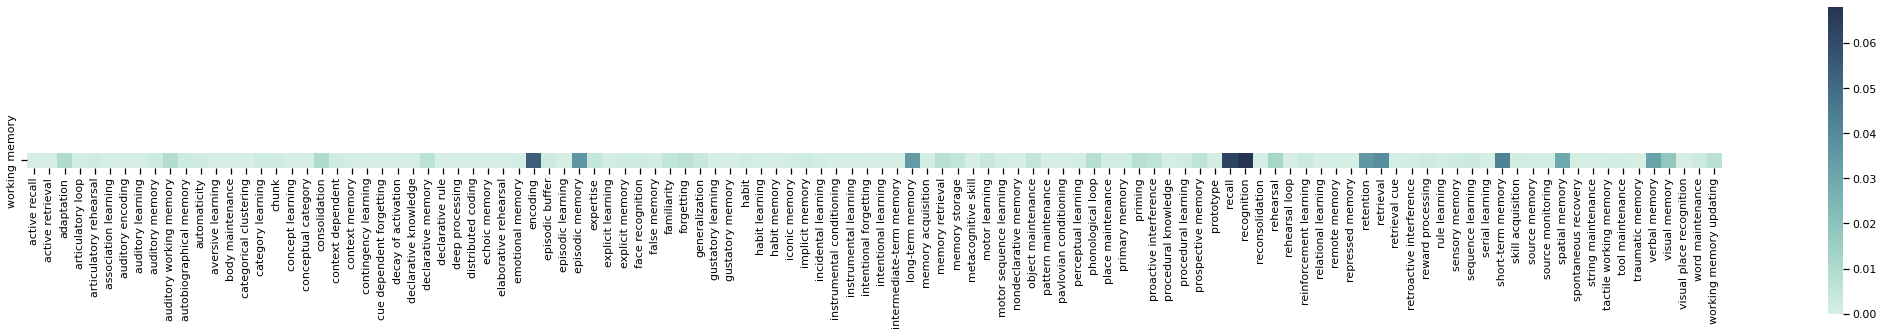

In [11]:
plot_matrix(pickle1, attribute='score', cmap='blue', figsize=(30, 5), square=True) # kwargs sent to seaborn

(-0.5, 2559.5, 1439.5, -0.5)

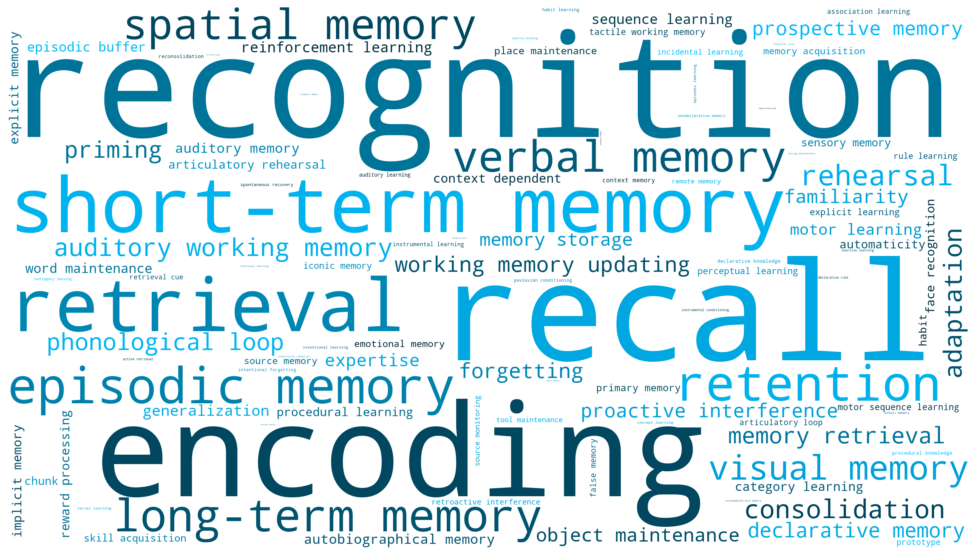

In [12]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

## **Co-occurances between "learning and memory" and "EEG features"** 

In [13]:
# Prepare Counts object
terms_c = sorted(concepts)
terms_d = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_d.remove('slow wave')

counts2 = Counts()
counts2.add_terms(terms_c, dim='A')
counts2.add_terms(terms_d, dim='B')

In [15]:
run_and_save(counts2, 'memlrn-eeg.p')

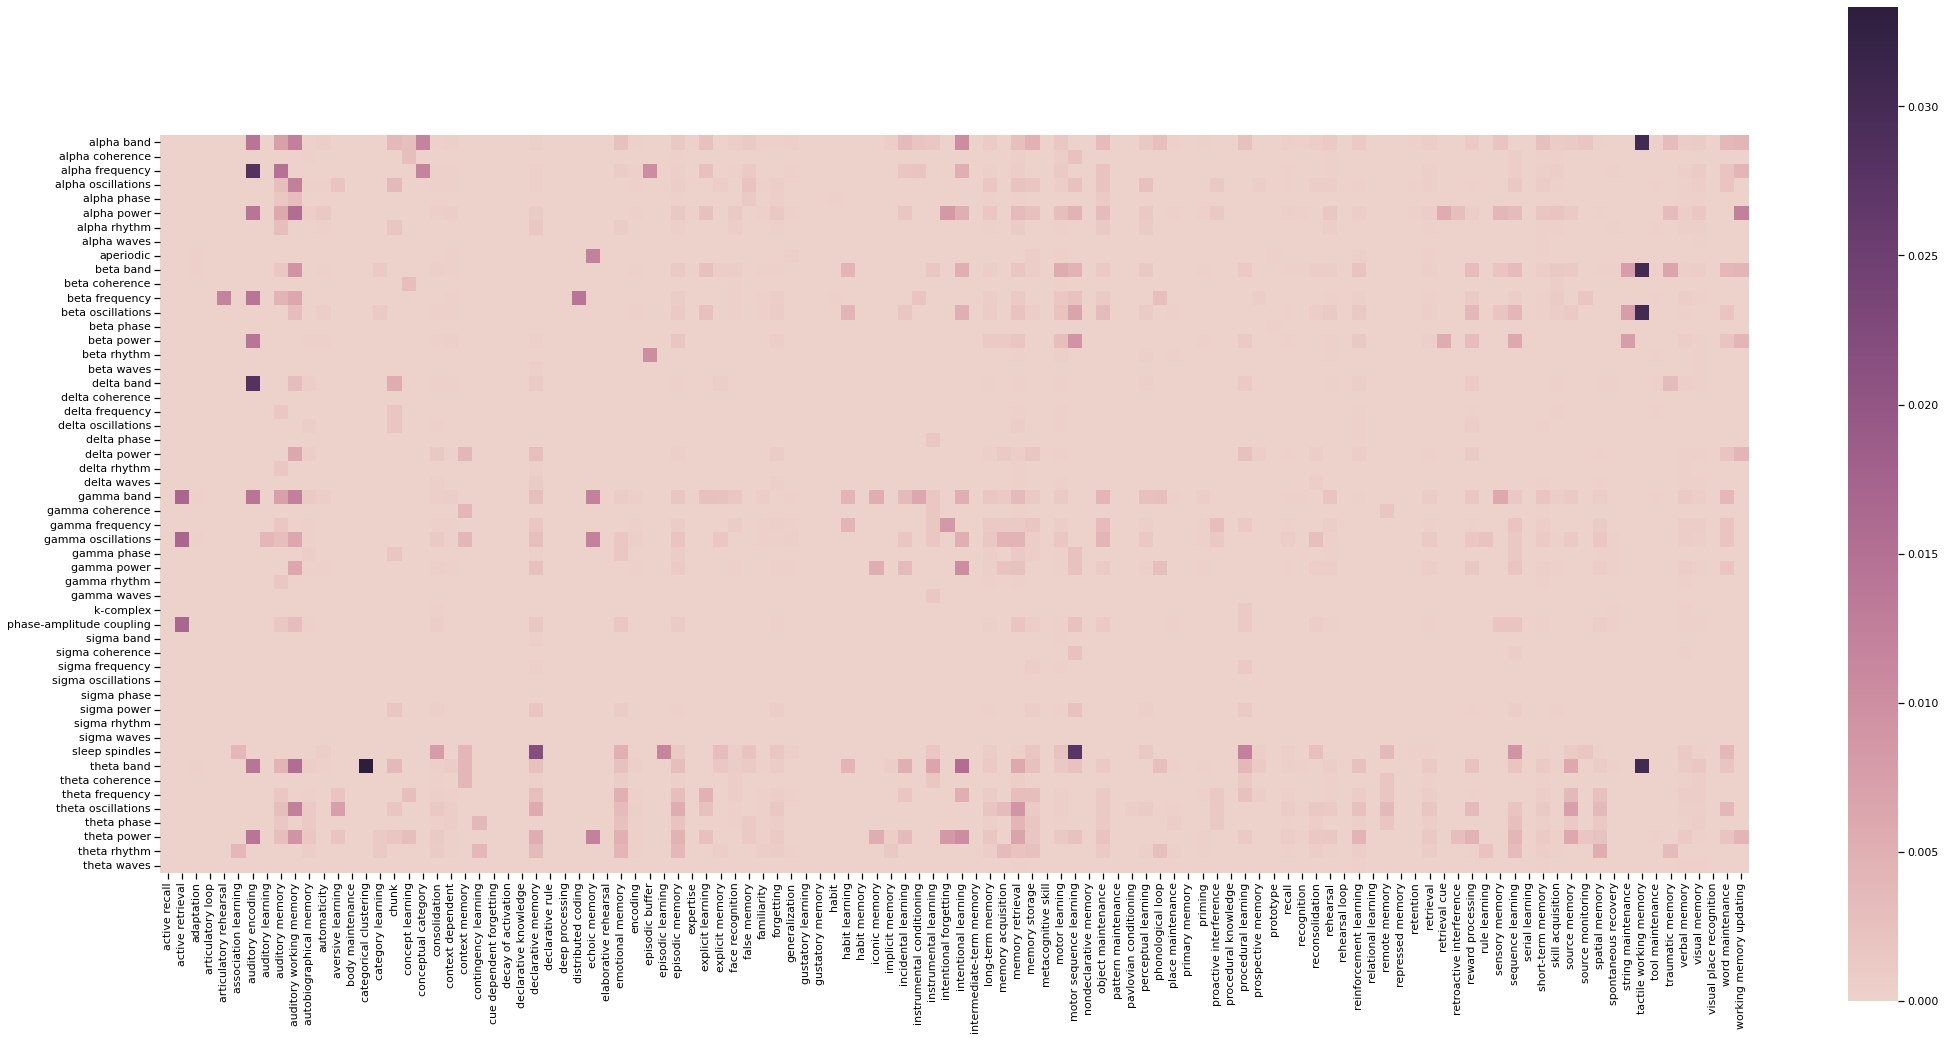

In [16]:
# Load the counts data and compute its scores
pickle2 = load_counts('memlrn-eeg.p')
pickle2.compute_score('normalize', dim='A')
plot_matrix(pickle2, attribute='score', transpose=True, figsize=(30, 15), square=True)

## **Perhaps this is too broad. Let's find cooccurances between "working memory" exclusively and "EEG features".**

In [26]:
top_terms = pick_top(pickle1, top_n=12)
pd.DataFrame(top_terms)

# Ignore this part underneath
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
wc = WordCloud(width=2560, height=1440, max_words=12, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

(-0.5, 2559.5, 1439.5, -0.5)

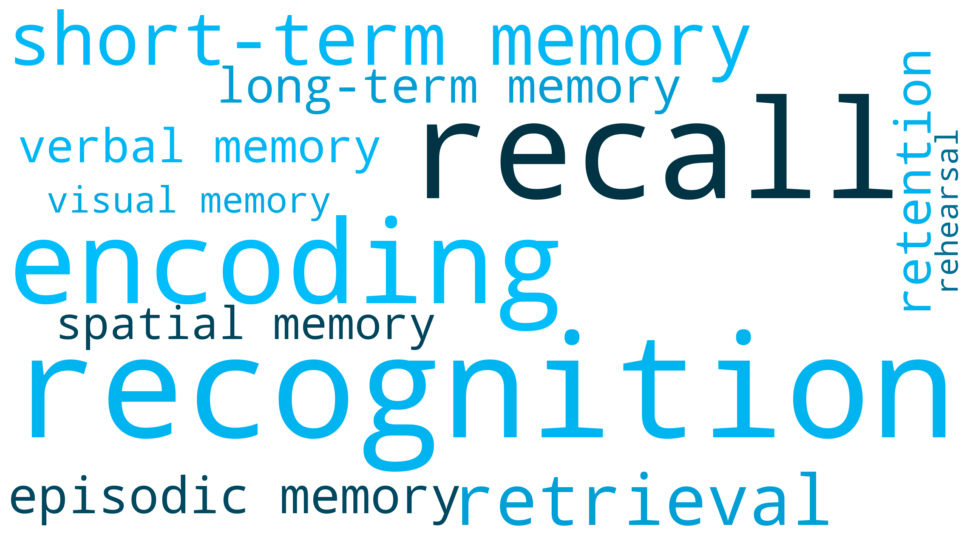

In [27]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

In [19]:
# Prepare Counts object
terms_e = list(zip(*pick_top(pickle1, top_n=12)))[1]
terms_f = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_f.remove('slow wave')

counts3 = Counts()
counts3.add_terms(terms_e, dim='A')
counts3.add_terms(terms_f, dim='B')

In [20]:
run_and_save(counts3, "wm-eeg.p")

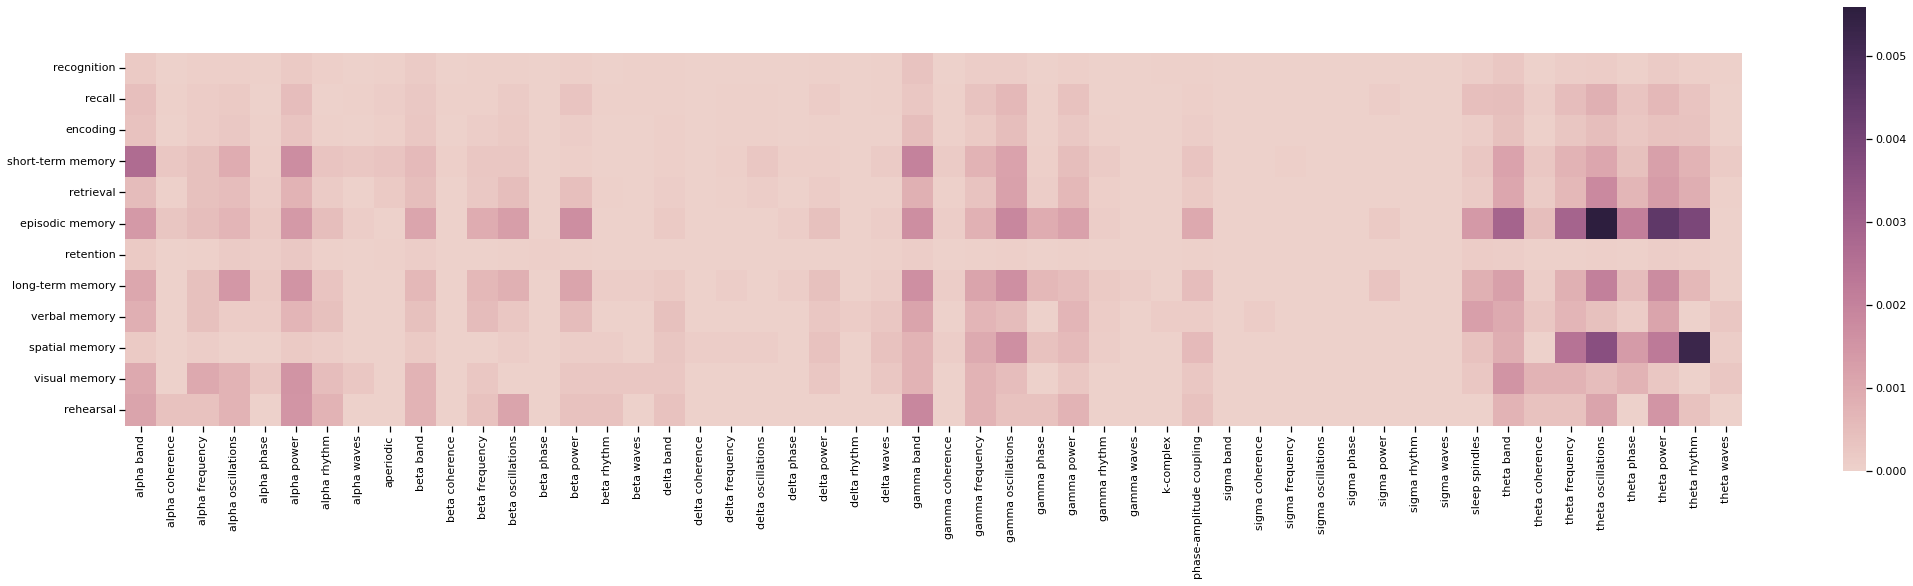

In [21]:
# Load the counts data and compute its scores
pickle3 = load_counts('wm-eeg.p')
pickle3.compute_score('normalize', dim='A')
plot_matrix(pickle3, attribute='score', cmap='purple', figsize=(30, 8), square=True)

# **Finally, what about cooccurances between "stages of sleep" and "working memory?"**

In [28]:
# Prepare Counts object
terms_g = stages
terms_h = terms_e = sorted(list(zip(*pick_top(pickle1, top_n=12)))[1])

counts4 = Counts()
counts4.add_terms(terms_g, dim='A')
counts4.add_terms(terms_h, dim='B')

In [29]:
run_and_save(counts4, "sleep-wm.p")

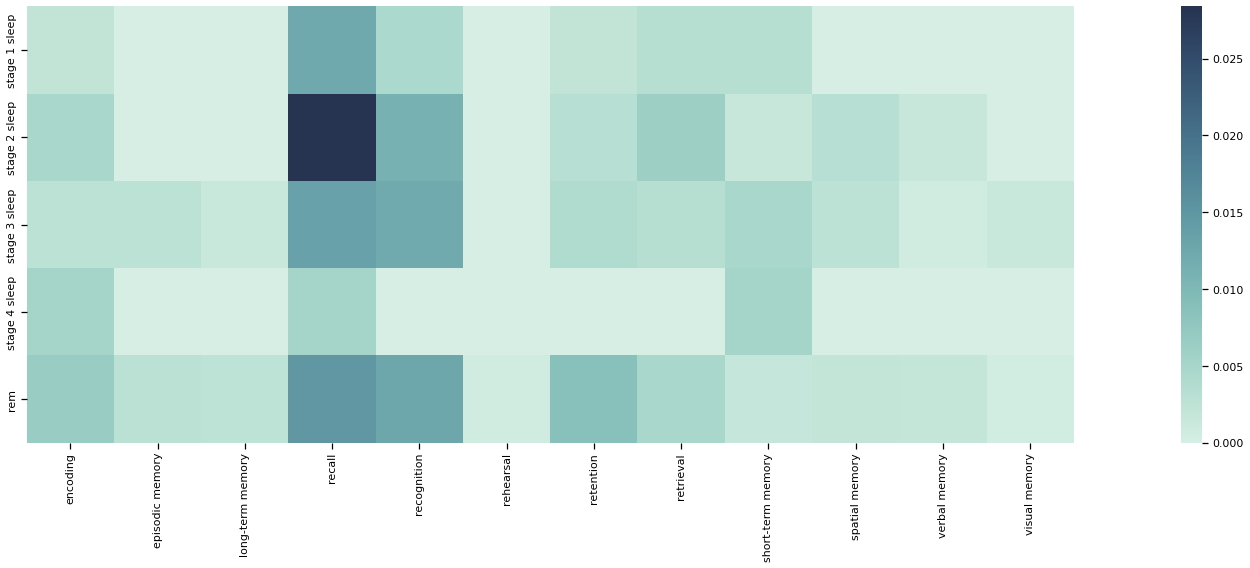

In [30]:
# Load the counts data and compute its scores
pickle4 = load_counts('sleep-wm.p')
pickle4.compute_score('normalize', dim='A')
plot_matrix(pickle4, attribute='score', cmap='blue', figsize=(30, 8), square=True)